## Sub-assignment 3:  Monte Carlo Methods *(2 points)*



# Introduction

This Jupyter Notebook explores the implementation of Monte Carlo methods for solving Markov Decision Processes (MDPs). 

In this notebook, we will focus on the episodic version of MDPs, where the agent interacts with the environment in discrete episodes. We will start by defining a simple MDP called CircleWorld, which has a finite number of states and actions. 

We will then implement Monte Carlo methods for both prediction and control. For prediction, we will estimate the state-value function for the optimal policy using an on-policy, first-visit Monte Carlo algorithm. For control, we will optimize the policy using an on-policy, first-visit Monte Carlo algorithm and epsilon-greedy action selection.

Let's get started!

## Prerequisite

This sub-assignment is built on top of the previous sub-assignments, so it is important to complete them before, and utilize defined components in this sub-assignment. 


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import time

For this exercise, we will use the *episodic* version of the MDP (`mdpe` instantiated below).

In [35]:
class CircleWorld():
	"""
	Generic base class for MDPs with finite state, action and reward spaces
	"""
	def __init__(self, n_states, n_actions, reward, task, gamma=1.0, state_labels=None, action_labels=None):
		"""
		n_states: number of states [0,...,N-1]
		n_actions: number of actions [0,...,N-1]
		reward: reward values
		task: episodic or continuing
		gamma: discounting factor
		"""
		self.n_states = n_states
		self.n_actions = n_actions
		self.state_labels = state_labels or np.arange(self.n_states)
		self.action_labels = action_labels or np.arange(self.n_actions)
		self.n_rewards = len(reward)
		self.reward = reward
		assert(task == 'episodic' or task == 'continuing')
		self.task = task
		self.gamma = gamma

	def reset(self):
		"""
		Sample initial state at start of the episode; assumed uniform
		"""
		return np.random.randint(self.n_states)

	def p_transition(self, s, a, s1, r):
		"""
		Transition density s x a => s1 x r
		"""
		# This only works for deterministic state transitions; otherwise override
		return np.float64((s1, r) == self.step(s, a))

	def step(self, s, a):
		"""
		Sample new state and reward when starting in s and taking action a
		:return new_state, reward_index: note that there are 3
		"""
		s1 = (s + 2 * a - 1) % self.n_states  # takes one step left or right
		if s1 == 0:
			r = 0
		else:
			r = 1
		return s1, r

	def sample_action(self, state, policy):
		# sample action from policy for a given state
		return np.random.choice(np.arange(self.n_actions), p=policy[state])

	def sample_episode(self, policy, T=None):
		"""
		Sample a finite horizon sequence from an MDP using some policy
		If the tasks is continuing then we sample exactly T steps
		If the task is episodic then we sample exactly one episode or reset until we sample T steps
		"""
		# sequence element is state, action, reward
		seq = []
		# randomly sample initial state NOTE: For exploring starts we would need to sample both states and actions. This is not needed for epsilon-greedy policies
		s = self.reset()

		if self.task == 'continuing':
			assert (T is not None)
			for t in range(T):
				a = self.sample_action(s, policy)
				(s1, r) = self.step(s, a)
				seq.append([s, a, self.reward[r]])
				s = s1
		else:
			t = 0
			while True:

				if T is None and self.is_terminal(s):
					break
				elif t == T:
					break

				a = self.sample_action(s, policy)
				if self.is_terminal(s):
					s1 = self.reset()
					r = 0
				else:
					(s1, r) = self.step(s, a)
				seq.append([s, a, self.reward[r]])
				s = s1
				t = t+1
		return seq

	def optimal_policy(self):
		"""
		For this simple task, the optimal policy is just to move to state zero as quickly as possible
		and then flip back and forth
		"""
		policy = np.zeros([self.n_states, self.n_actions])
		n = int(np.round(self.n_states/2))
		policy[:n, 0] = 1.0
		policy[n:, 1] = 1.0
		policy[self.terminal_states(), :] = 1.0 / self.n_actions
		return policy

	def random_deterministic_policy(self):
		"""
		Random choice of a deterministic action for each state
		"""
		return np.random.multinomial(1, [1.0 / self.n_actions for a in range(self.n_actions)], self.n_states).astype('float32')

	def nonterminal_states(self):
		"""
		:return: The set S of nonterminal states
		"""
		return [s for s in range(self.n_states) if not self.is_terminal(s)]

	def terminal_states(self):
		"""
		:return: The set S of terminal states
		"""
		return [s for s in range(self.n_states) if self.is_terminal(s)]

	def is_terminal(self, s):
		"""
		flags if s is a terminal state
		"""
		if self.task == "episodic":
			return s == 0
		else:
			return False

	def q_to_v(self, q, policy):
		"""
		Convert Q-value to state value
		:param q:
		:param policy:
		:return:
		"""
		v = np.zeros(self.n_states)
		for s in self.nonterminal_states():
			for a in range(self.n_actions):
				v[s] += policy[s, a] * q[s, a]
		return v

	def v_to_q(self, v):
		"""
		Convert state value to Q-value
		:param v:
		:return:
		"""
		q = np.zeros([self.n_states, self.n_actions])
		for s in self.nonterminal_states():
			for a in range(self.n_actions):
				q[s, a] = sum(self.p_transition(s, a, s1, r) * (self.reward[r] + self.gamma * v[s1])
				              for s1 in range(self.n_states) for r in range(self.n_rewards))
		return q

	# some simple rendering methods
	def __str__(self):
		str = "task: {0}\n".format(self.task)
		str += "states: {0}\n".format(self.state_labels)
		if self.terminal_states():
			str += "terminal states: {0}\n".format(self.terminal_states())
		str += "actions: {0}\n".format(self.action_labels)
		str += "rewards: {0}\n".format(self.reward)
		str += "discounting factor: {0}".format(self.gamma)
		return str

	def print_policy(self, policy):
		for s in range(self.n_states):
			a = np.random.choice(np.arange(self.n_actions), p=policy[s])
			print('state ' + str(self.state_labels[s]) + ' => action ' + str(self.action_labels[a]))

	def print_value(self, vf):
		"""
		:param vf: state value or action value function
		"""
		if vf.ndim == 1:
			for s in range(self.n_states):
				print('state ' + str(self.state_labels[s]) + ': ' + str(vf[s]))
		else:
			for s in range(self.n_states):
				for a in range(self.n_actions):
					print('state ' + str(self.state_labels[s]) + ' - action ' + str(self.action_labels[a] + ': ' + str(vf[s,a])))

In [36]:
mdpe = CircleWorld(n_states=10, n_actions=2, reward=[1.0, -1.0 /(10 - 1)], task='episodic', gamma=1.,
                   state_labels=None, action_labels=['L', 'R'])
print(mdpe)

task: episodic
states: [0 1 2 3 4 5 6 7 8 9]
terminal states: [0]
actions: ['L', 'R']
rewards: [1.0, -0.1111111111111111]
discounting factor: 1.0


**a**) Why do we need to use an *episodic* task? (0.2 point)

We use an episodic task to ensure that well defined returns are available - value estimates and policies are only updated after the completion of a full episode. This allows Monte Carlo methods to update in an episode-by-episode manner, but not in a step-by-step (online) manner. If a continuous task were used it would be difficult to decide when the value function and policy should be updated.

**b**) **MC Prediction** (0.9 point): Implement an *on-policy, first-visit MC* algorithm to estimate the state-value function for
the optimal policy
. This should be provided as a function `mc_prediction` that takes in the initial policy and
 a parameter specifying how many sample episodes to run. Use your implementation to calculate the approximate state
 value function $V_{\pi}$ for the optimal policy $\pi_{*}$. Plot the MSE between the estimated value function and the
  true optimal $v_{*}$ as a function of number of episodes, i.e. how the accuracy of the estimate evolves across
  episodes.

In [52]:
def find_reversed_first_visits(episode):
	first_visits = {}
	visited_states = set()

	for index, step in enumerate(episode):
		state, action, reward = step
		if state not in visited_states:
			visited_states.add(state)
			first_visits[state] = len(episode)- 1 - index

	return first_visits



def mc_prediction(mdp: CircleWorld, policy, num_simulations=30):
	# Conditions for convergence
	assert(mdp.task == 'episodic')
	

	Vs = []
	V = [0 for i in range(10)]
	Returns = [0 for i in range(10)]
	Counts= [0 for i in range(10)]

	# Generating num_simulations episodes
	for i in range(num_simulations):

		# Generate new episode
		episode = mdp.sample_episode(policy)

		# Determine first-visit timestep for each state
		first_visits = find_reversed_first_visits(episode)

		G = 0
		
		# Iterating over steps in an episode
		for timestep, step in enumerate(reversed(episode)):
			state, action, reward = step

			G = G*mdp.gamma + reward

			# If this is the first time state is observed in sequence, then add to Returns
			if timestep == first_visits[state]:
				Returns[state] += G
				Counts[state] += 1
				V[state] = Returns[state]/Counts[state]

		Vs.append(V.copy())

	return V, Vs

In [97]:
policy = mdpe.optimal_policy()

V, value_functions_mc = mc_prediction(mdpe, policy, num_simulations=30)
print(V)

[0, 1.0, 0.8888888888888892, 0.7777777777777777, 0.6666666666666665, 0.5555555555555554, 0.6666666666666665, 0.7777777777777777, 0.8888888888888892, 1.0]


Did not converge
[887.88888889 888.88888889 888.77777778 888.66666667 888.55555556
 884.88888889 885.88888889 886.88888889 887.88888889 888.88888889]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]


Text(0.5, 1.0, 'State value')

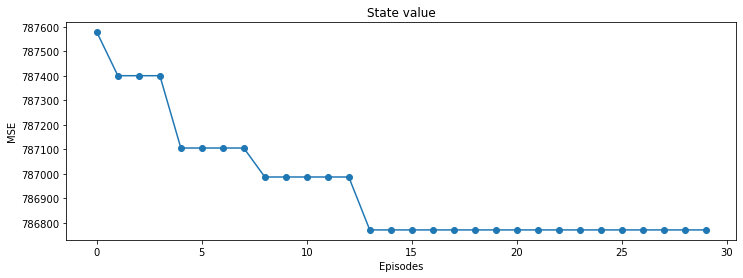

In [95]:
# plots
# Somehow need to get the true value of the optimal policy to compare it with the value of the approximation from MC
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
pi_e = mdpe.optimal_policy()

# True values seem to be messed up here... not sure why the 
V_e = policy_evaluation(mdpe, pi_e, max_t=1000)
print(V_e)

time_axis_pi = np.arange(len(value_functions_mc))
print(time_axis_pi)
ax.plot(time_axis_pi, list(map(lambda x: np.mean((x - V_e)**2), value_functions_mc)), '-o', label='policy iteration')
ax.set_xlabel('Episodes')
ax.set_ylabel('MSE')
ax.set_title('State value')


**c**) **MC Control** (0.9 point): Implement an *on-policy, first-visit MC* algorithm to optimize the policy. To do this, you will
need to
estimate the Q-value function (computing returns after first visit to state-action pairs) and use it to take an
$\epsilon$-greedy action selection to gradually improve the policy. This should be provided as a function
`mc_control` that takes in the initial policy, the number of episodes to use and `epsilon` to set the mininum action
probability. Run for 200 episodes and plot the MSE between the estimated q-value function and the
  true optimal $q_{*}$ as a function of number of episodes. Note: you can obtain the $q_{*}$ from
$v_{*}$ using the method `mdpe.v_to_q()`.

In [40]:
def mc_control(mdp, policy, num_simulations=30, epsilon=0.01):
	"""
	Run the Monte Carlo First Visit On-Policy algorithm and return the estimated
	policy, Q (state action) values, and returns (rewards) dict.
	Uses epsilon-soft policies instead of exploring starts
	:param mdp:
	:param policy: any epsilon soft policy; e.g. mdp.uniform_stochastic_policy()
	:param num_simulations : int Number of episodes for the policy iteration process
	:param epsilon: epsilon-soft minimum probability

	:return policy: numpy.ndarray Estimated Policy
	:return Q: numpy.ndarray Estimated Q (state-action) values
	:return R: dict Returns obtained for every state
	"""
	# Conditions for convergence
	assert(mdp.task == 'episodic')

	Q = np.zeros([mdp.n_states, mdp.n_actions])

	# TODO

	return policy, Qs

compare with uniform stochastic policy in the previous part

In [41]:
policy0 = uniform_stochastic_policy(mdpe.n_states, mdpe.n_actions)
policy_mc, Qs_mc = mc_control(mdpe, policy0, num_simulations=10000, epsilon=0.01)

NameError: name 'uniform_stochastic_policy' is not defined

In [ ]:
# plots